Импортируем нужные библиотеки

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')

Устанавливаем настройки для графиков

In [30]:
sns.set(
    font_scale=1.5,
    style = 'whitegrid',
    rc = {'figure.figsize':(20,7)}
)

### Проект: Вариант 1

#### Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Задание 1

#### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

Импортируем данные в ноутбук

In [16]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [24]:
def RR (auth_data, reg_data):
    #Запрашиваем данные
    start_date = input('Введите начальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД ')
    final_date = input('Введите финальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД ')
    print('Спасибо! Расчет займет некоторое время, ожидайте ответа')
    # Приводим данные к нужному формату
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'],unit='s')
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'],unit='s')

    # Убираем время из даты
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'].dt.date)
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'].dt.date)

    # Делаем мердж по id пользователя
    df = reg_data.merge(auth_data, on='uid')

    # Устанавливаем диапазон дат для анализа
    df = df[(df['reg_ts'] >= start_date) & (df['reg_ts'] <= final_date)]

    # Расчитываем количество дней с регистрации
    df['days_since_reg'] = (df['auth_ts'] - df['reg_ts']).dt.days

    # Находим размер когорты для каждого дня регистрации
    c_size = reg_data.groupby('reg_ts')['uid'].nunique().reset_index().rename(columns={'uid':'c_size'})

    # Расчитываем количество уникальных пользователей по дням после регистрации и добавляем таблицу с размером всей когорты
    final_result = (df.groupby(['reg_ts','days_since_reg'])['uid'].nunique().reset_index()).merge(c_size, on='reg_ts') 

    # Расчитываем ретеншт в виде отношения количества пользователей к размеру когорты
    final_result['retention'] = final_result['uid'] / final_result['c_size'] 

    # Добавляем столбец с когортами в формате строки
    final_result['cohorts'] = report['reg_ts'].astype('str')

    # Делаем сводную табилцу для когортного анализа
    final_result_svod = final_result.pivot_table(index='cohorts', columns='days_since_reg', values='retention')

    # Оформляем таблицу
    final_result_svod_graph = (final_result_svod \
                .style
                .background_gradient(cmap='YlOrRd')
                .highlight_null('white')
                .set_caption('Когортный анализ ретеншена')
                .format("{:.2%}", na_rep=""))
    return final_result_svod_graph

In [28]:
RR(auth_data, reg_data)

Введите начальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД 2020-09-10
Введите финальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД 2020-10-10
Спасибо! Расчет займет некоторое время, ожидайте ответа


days_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohorts,,,,,,,,,,,,,,
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 

##### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Импортируем данные в ноутбук

In [31]:
ab_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-shelekhov/Final Project My/Проект_1_Задание_2.csv', sep=';')

Проанализирем данные на пропуски и нули

In [33]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [34]:
ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим на количество пользователей в каждой выборке

In [36]:
ab_test.groupby('testgroup').agg({'user_id': 'count'}).reset_index()

,testgroup,user_id
0,a,202103
1,b,202667


Посмотрим на среднее значение revenue у пользователей в каждой выборке

In [38]:
ab_test.groupby('testgroup').agg({'revenue': 'mean'}).reset_index()

,testgroup,revenue
0,a,25.413720
1,b,26.751287


Как видим revenue в тестовой группе выше

Построим боксплот чтобы визуализировать даннные

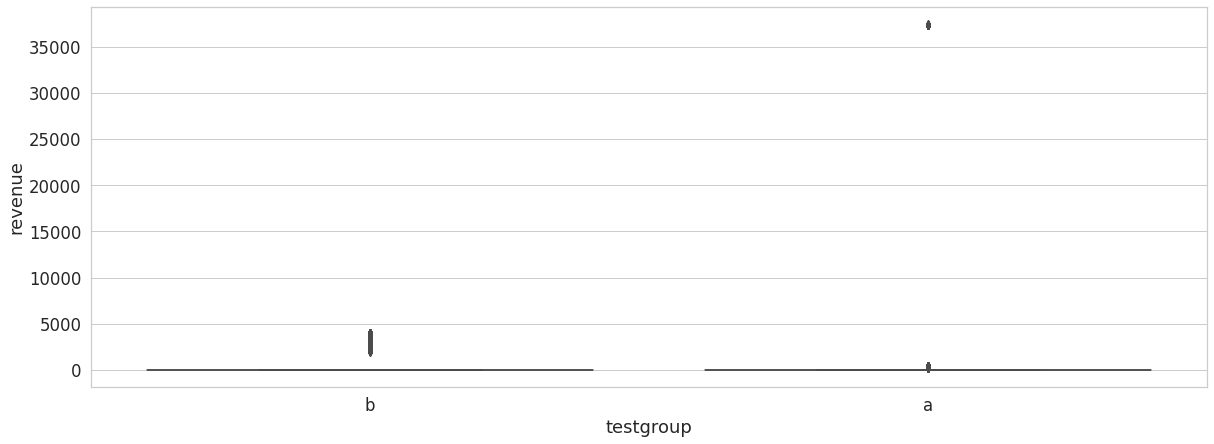

In [40]:
sns.boxplot(x="testgroup", y="revenue", data=ab_test)

Как мы видим большое количество не платящих пользователей значительно смещает распределение к нулю.
Отфильтруем только по платящим и еще раз посмотрим на распределение:

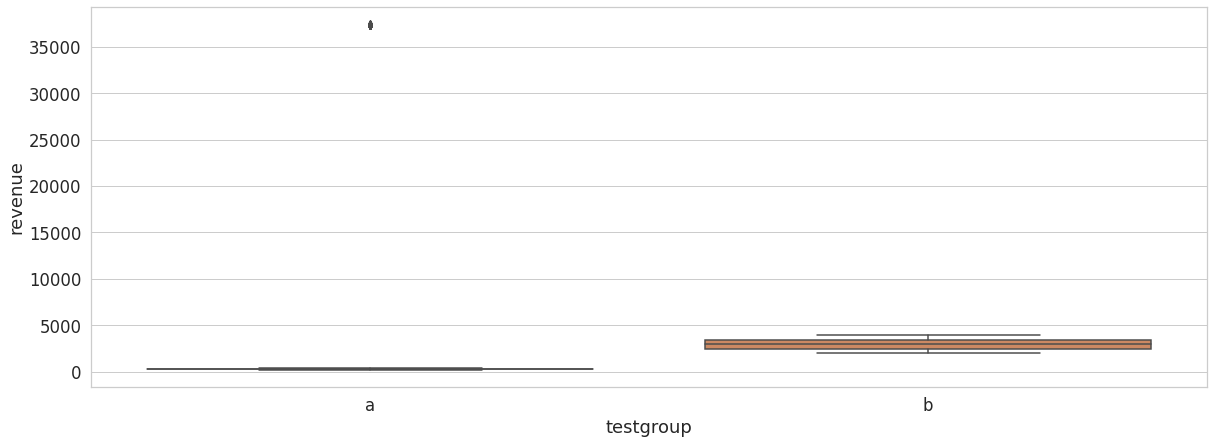

In [41]:
sns.boxplot(x="testgroup", y="revenue", data=ab_test.query('revenue > 0'))

По данному распределению можно заметить, что не смотря на то что количество платящих у нас уменьшилось, средний чек в тестовой группе у нас вырос

Построим также на распределение выручке на графике дисплот для всей выборки

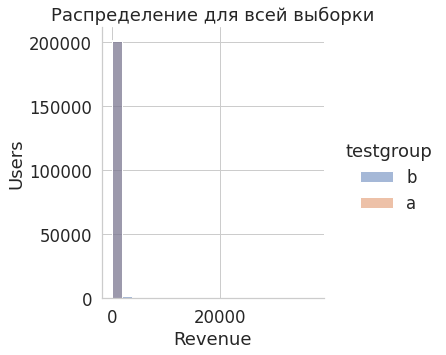

In [84]:
fig = sns.displot(data = ab_test, x = 'revenue', hue='testgroup', kde=False)
plt.xlabel("Revenue")
plt.ylabel("Users")
plt.title("Распределение для всей выборки")
plt.show(fig)

И только для платящих пользователей

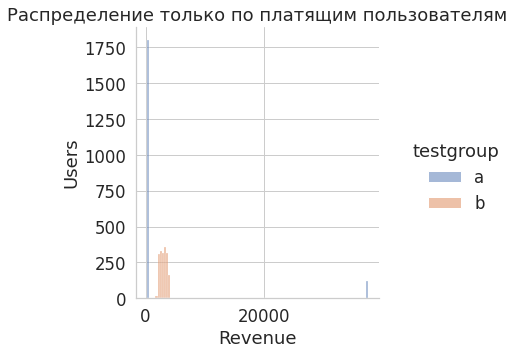

In [85]:
ашп = sns.displot(data = ab_test.query('revenue > 0'), x = 'revenue', hue='testgroup', kde=False)
plt.xlabel("Revenue")
plt.ylabel("Users")
plt.title("Распределение только по платящим пользователям")
plt.show(fig)

###### Как мы видим распределение у нас отличается от нормального а также присутствуют выбросы, поэтому сравнить при помощи t-теста, две выборки мы не можем
###### Остается два варианта: Тест Манна-Уитни и Бутстрап

###### Проводим Тест Манна-Уитни

In [87]:
mannwhitneyu(ab_test[ab_test.testgroup == 'a'].revenue, 
             ab_test[ab_test.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Так как мы получаем значение p > 0,05 то мы не можем отклонить нулевую гипотезу о статистической разнице между нашими группами

###### Проведем Тест Манна-Уитни только для платящих пользователей

In [88]:
mannwhitneyu(ab_test[ab_test.testgroup == 'a'].query('revenue > 0').revenue, 
             ab_test[ab_test.testgroup == 'b'].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

В данном случае мы получавем  p < 0,05 и это означает что нулевую гипотезу при сравнении только платящих пользователей отклонить можно, но лучше проверить данные группы также и при помощзи бутстрапа. Так как интерпровать теста Манна-Уитни сложно для решения бизнес-задач.

###### Проводим анализ при помощи Бутстрап

In [90]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

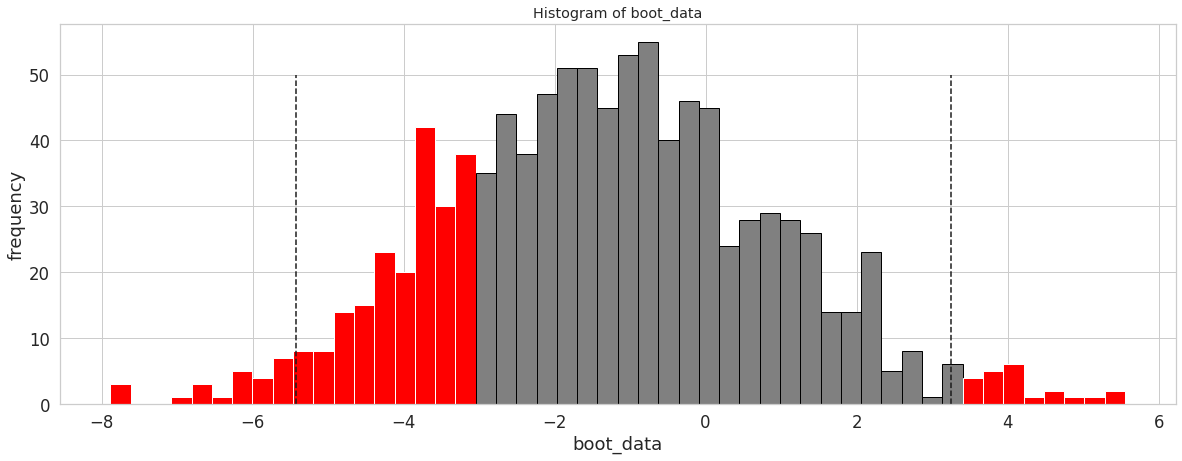

{'boot_data': [-1.434180206940449,
  -1.9191580277006124,
  0.013371688533407018,
  -0.9024014763133613,
  -0.18135660961083946,
  -0.7130909324162296,
  -0.19045527885644925,
  -0.6513788628637124,
  0.03803776638525266,
  0.6911139948782979,
  -7.884357098096878,
  -0.25207359856316025,
  -2.1032087118277767,
  1.28111137975102,
  -4.649898602140457,
  3.904794564482624,
  -3.22297660694637,
  -3.02602298351483,
  1.7383787197718426,
  -1.1581165162557299,
  -4.101205425648971,
  -5.424232854880173,
  -0.20754735600763816,
  -1.3913611984190815,
  -1.5821026610153601,
  -5.356106322193549,
  0.9542254042345325,
  1.2934320831709158,
  -4.698002141443847,
  3.913957378359575,
  -1.0898370232943695,
  1.1026116733360636,
  -1.2157677372241165,
  4.411211494717937,
  0.7172307282389339,
  -4.009592089486695,
  -1.1829454227871337,
  0.3030883172889518,
  0.9148455347935283,
  -0.029703898513324813,
  -3.1140540887268275,
  -4.261655819645034,
  -0.45304366275713365,
  -4.707337652405177

In [91]:
get_bootstrap(
    ab_test[ab_test.testgroup == 'a'].revenue, # числовые значения первой выборки
    ab_test[ab_test.testgroup == 'b'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

###### Так как 0 на графике у нас входит в доверительный интервал, то мы можем сказать что среднее значение между Тестовой и Контрольной группой не изменилось статистически значимо

Проверим также на выборке среди платящих клиентов

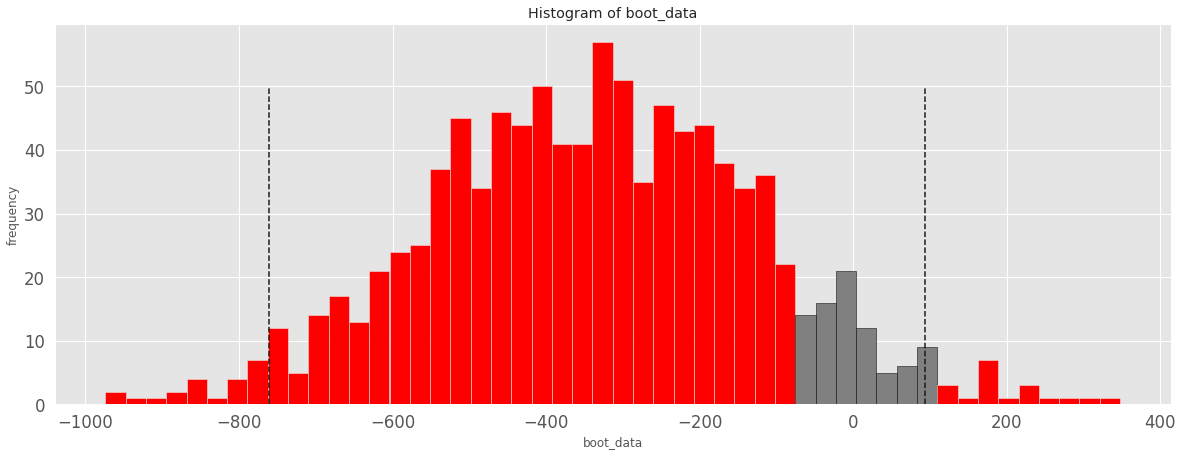

{'boot_data': [-535.4528008298755,
  -449.850622406639,
  -196.74221991701245,
  -760.8386929460581,
  -418.76141078838174,
  -102.6649377593361,
  -470.8454356846473,
  -99.91130705394191,
  -323.75,
  -132.03423236514521,
  -545.3661825726141,
  -502.10736514522824,
  -600.4356846473029,
  -103.9548755186722,
  -6.5,
  -582.7090248962655,
  -678.652489626556,
  -373.6623443983402,
  -238.13796680497924,
  -625.5627593360996,
  -316.6130705394191,
  0.050311203319502076,
  -233.96213692946057,
  -505.28890041493776,
  -269.4190871369295,
  -726.5051867219917,
  -378.6701244813278,
  -584.9476141078839,
  -191.51970954356847,
  -230.96161825726142,
  -257.06172199170123,
  -756.9491701244814,
  -475.32053941908714,
  -130.42427385892117,
  -229.4808091286307,
  23.571058091286307,
  -239.96628630705393,
  -734.88744813278,
  122.1301867219917,
  -691.268153526971,
  -227.82728215767634,
  -206.73495850622407,
  -103.69242738589212,
  -247.99273858921163,
  -335.57676348547716,
  -551.1

In [93]:
get_bootstrap(
    ab_test[ab_test.testgroup == 'a'].query('revenue > 0').revenue, # числовые значения первой выборки
    ab_test[ab_test.testgroup == 'b'].query('revenue > 0').revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

###### Также как и в прошлом случае  0 на графике у нас входит в доверительный интервал, и мы можем сказать что среднее значение между Тестовой и Контрольной группой не изменилось статистически значимо и среди платящих пользователей

##### ВЫВОД - Оставляем вариант А, так как мы не получили статически значимый результат в тестовой группе

### Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?



###### Метрики:

###### Дневная аудитория (DAU) — количество уникальных пользователей, которые зашли в приложение в течение суток. Отслеживая эту метрику мы будем понимать привлекают ли пользователей наши тематические события.

###### Месячная аудитория (MAU) — количество уникальных пользователей, которые зашли в приложение в течение месяца. По отношению средней дневной аудитории к месячной можно понимать частоту использования продукта.

###### avg. DAU/MAU = stickness ratio — коэффициент того, насколько часто пользователи, в течение одного периода, "остаются" в продукте. Если тематическме события заставляют пользователей чаще заходить в продукт мы это увидим.

###### Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие (прошли ряд уровней) к общему числу пользователей. Важно отслеживать также на каких этапах пользователи отваливаются, так мы сможем проработать следующие события чтобы увеличить конверсию а значит и вовлеченность пользователей в продукт.

###### Retention rate (RR) — коэффициент удержания клиентов. Чем дольше мы удерживаем пользователей тем лучше для нашего продукта.

###### Churn rate (отток клиентов) - также важно следить за оттоком клиентов из продукта. Если мы увидим большой отток то это важный сигнал к тому что что-то клиентам не нравится.

######  Средняя продолжительность сессии (average session length, ASL) - важно посмотреть насколько меняется продолжительность сессии пользователя в продукте. Желательно чтобы этот показатель рос, а не снижался.


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как? 


###### Я бы оставил прежний набор метрик, но больше внимания обращал на RR, Churn rate и ASL, так как описанный выше экпириенс может расстраивать пользователя и он может реже пользоваться продуктом. 